<a href="https://colab.research.google.com/github/Enricjfz/DataScience/blob/main/SeriesTemporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Data Science Project on Time Series

Basado en el proyecto realizado en la página https://thecleverprogrammer.com/2020/05/08/data-science-project-on-time-series/

##Obtención de los datos

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Fremont-Bridge-Bicycle-Counts/master/fremont-bridge.csv',index_col= 'Date', parse_dates= True)

In [ ]:
df.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


Bicycle counts on Seattle’s Fremont Bridge. This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.

In [3]:
df.columns = ["West", "East"]
df["Total"] = df["West"] + df["East"]
df.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


## Análisis Exploratorio

In [ ]:
df.describe()

,West,East,Total
count,45976.000000,45976.000000,45976.000000
mean,54.712306,55.479315,110.191622
std,72.935797,80.232055,139.189603
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,60.000000
75%,72.000000,68.000000,144.000000
max,854.000000,717.000000,1165.000000


In [ ]:
df.isna().sum()

West     8
East     8
Total    8
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.isna().sum()

West     0
East     0
Total    0
dtype: int64

In [ ]:
df.dtypes

West     float64
East     float64
Total    float64
dtype: object

In [ ]:
df.index

DatetimeIndex(['2012-10-03 00:00:00', '2012-10-03 01:00:00',
               '2012-10-03 02:00:00', '2012-10-03 03:00:00',
               '2012-10-03 04:00:00', '2012-10-03 05:00:00',
               '2012-10-03 06:00:00', '2012-10-03 07:00:00',
               '2012-10-03 08:00:00', '2012-10-03 09:00:00',
               ...
               '2017-12-31 14:00:00', '2017-12-31 15:00:00',
               '2017-12-31 16:00:00', '2017-12-31 17:00:00',
               '2017-12-31 18:00:00', '2017-12-31 19:00:00',
               '2017-12-31 20:00:00', '2017-12-31 21:00:00',
               '2017-12-31 22:00:00', '2017-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=45976, freq=None)

<Axes: xlabel='Date', ylabel='Total'>

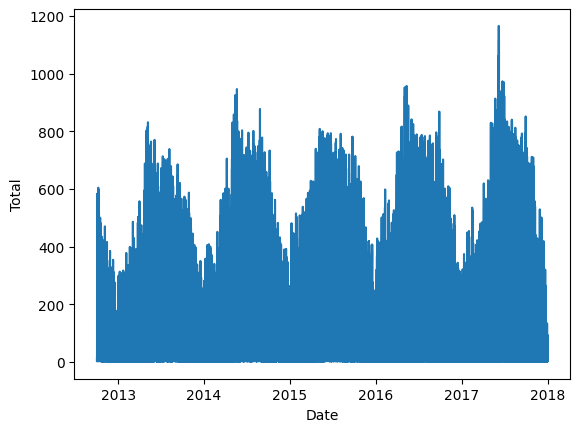

In [ ]:
sns.lineplot(x="Date", y="Total",
             data=df)

In [6]:
weekly = df.resample("W").sum()
weekly.head()

,West,East,Total
Date,,,
2012-10-07,7297.0,6995.0,14292.0
2012-10-14,8679.0,8116.0,16795.0
2012-10-21,7946.0,7563.0,15509.0
2012-10-28,6901.0,6536.0,13437.0
2012-11-04,6408.0,5786.0,12194.0


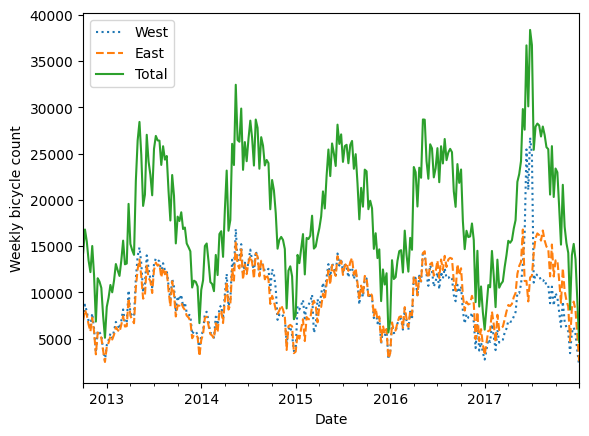

In [7]:
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')
plt.show()

## Aplicación modelo ARIMA

In [8]:
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss

<Axes: xlabel='Date'>

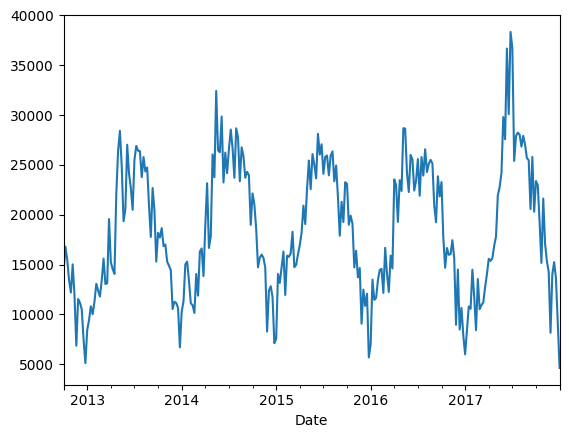

In [9]:
weekly_total = weekly['Total']
weekly_total.plot()

In [ ]:
weekly_total.shape

(274,)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

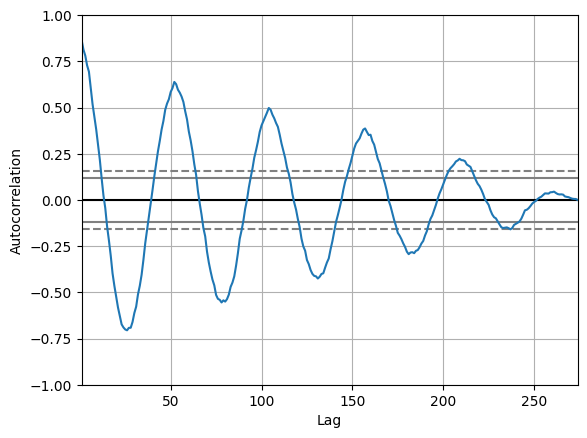

In [ ]:
autocorrelation_plot(weekly_total)

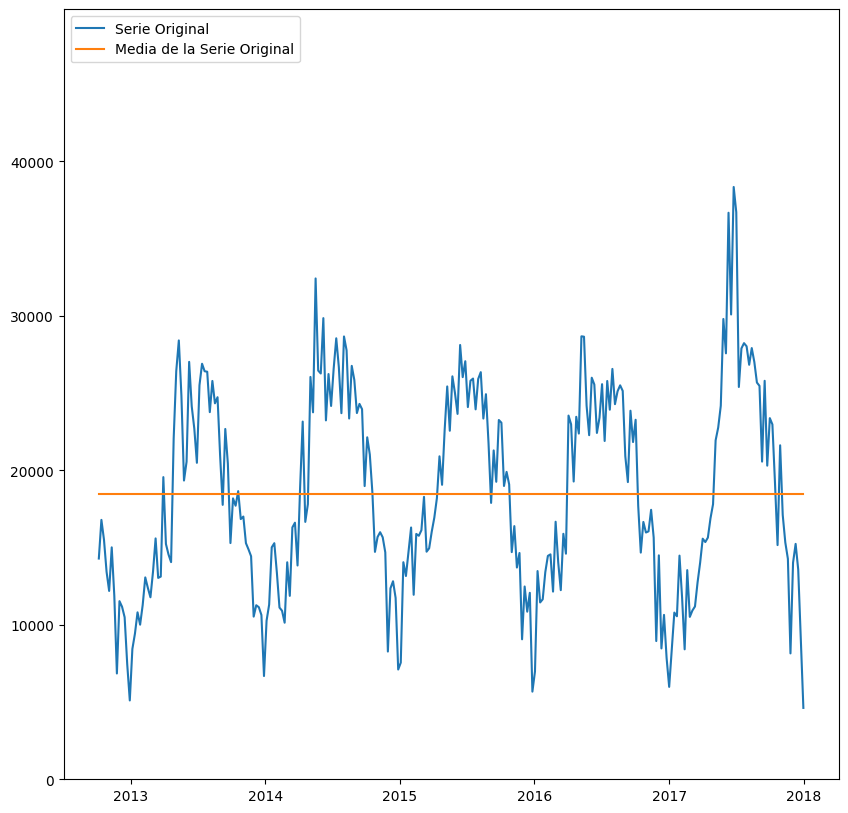

In [ ]:
x = weekly_total.index
y = weekly_total
y_media = [np.mean(y) for _ in y]
fig = plt.figure(figsize = (10, 10))
ax1 = fig.subplots(1, 1)
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

In [11]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('Resultados de la Prueba ADF:')
    print('Valor p:', result[1])
    print('Estadística ADF:', result[0])
    print('Valores críticos:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [12]:
adf_test(weekly_total)

Resultados de la Prueba ADF:
Valor p: 2.2941693673477652e-07
Estadística ADF: -5.9381887019794934
Valores críticos:
	1%: -3.4558530692911504
	5%: -2.872764881778665
	10%: -2.572751643088207


Sabemos entonces que la serie es estacionaria y tiene componente estacional, luego podemos usar un modelo SARIMA o eliminar la componente estacional mediante diferenciación y así usar un modelo ARIMA

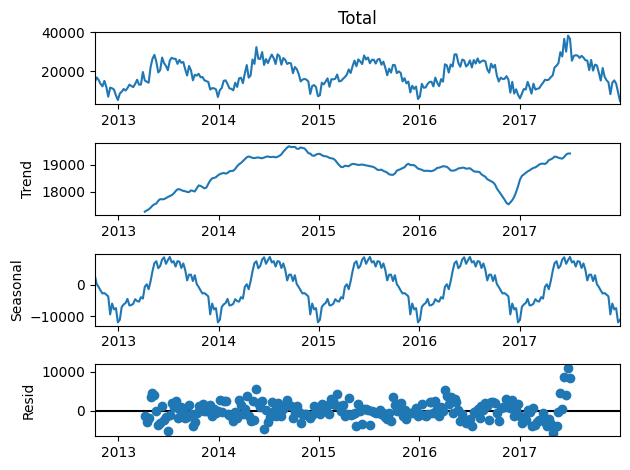

In [13]:
decompose_result_add = seasonal_decompose(weekly_total, model="additive")
trend = decompose_result_add.trend
seasonal = decompose_result_add.seasonal
residual = decompose_result_add.resid
decompose_result_add.plot();

In [ ]:
decompose_result_mult = seasonal_decompose(weekly_total, model="multiplicative")

In [14]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [15]:
from pmdarima import auto_arima

In [16]:
stepwise_model = auto_arima(weekly_total, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5155.453, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5076.365, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5131.396, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5023.887, Time=4.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5046.179, Time=0.93 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5041.398, Time=2.59 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5043.543, Time=3.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5041.885, Time=1.83 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5019.525, Time=11.01 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=

El mejor modelo SARIMA tiene un AIC muy alto

In [18]:
train = weekly_total.iloc[0:220]
test = weekly_total.iloc[221:274]

In [19]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=54)
print(future_forecast)

2016-12-25    10480.038752
2017-01-01     9319.674079
2017-01-08     8625.047070
2017-01-15    11100.251259
2017-01-22    11268.719006
2017-01-29     9035.368074
2017-02-05     9827.613306
2017-02-12     9613.190506
2017-02-19     6399.444818
2017-02-26     6421.631210
2017-03-05     6185.329117
2017-03-12     6793.415250
2017-03-19     6223.956555
2017-03-26     5298.870466
2017-04-02     3878.906984
2017-04-09     6010.861181
2017-04-16     5335.070310
2017-04-23     4576.928802
2017-04-30     5575.550981
2017-05-07     4721.868791
2017-05-14      370.214989
2017-05-21     1147.483303
2017-05-28     1170.377623
2017-06-04     1177.021196
2017-06-11     1506.020820
2017-06-18    -1179.578516
2017-06-25    -2898.079257
2017-07-02     -787.188361
2017-07-09    -1186.031567
2017-07-16    -2095.867085
2017-07-23     -971.939961
2017-07-30    -2021.694733
2017-08-06    -6854.254289
2017-08-13    -4644.232977
2017-08-20    -6774.289040
2017-08-27    -5874.646649
2017-09-03    -5937.572663
2

In [ ]:
future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])

In [ ]:
test_forecast = pd.concat([test, future_forecast], axis=1)

<Axes: xlabel='Date'>

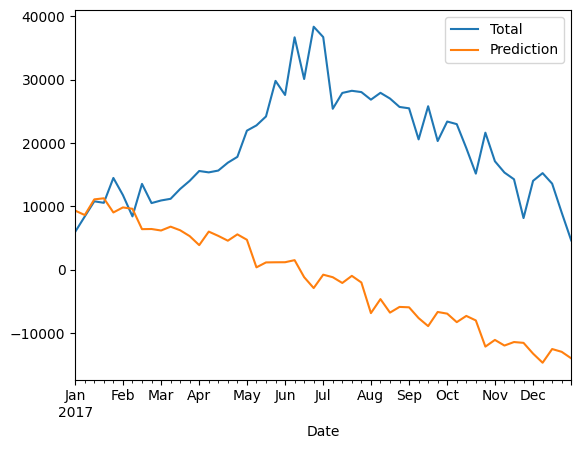

In [ ]:
test_forecast.plot()

Vemos que la predicción no es satisfactoria. Observamos los residuos del modelo

In [23]:
print(stepwise_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8838      0.051    -17.270      0.000      -0.984      -0.783
ma.L1          0.6045      0.076      7.982      0.000       0.456       0.753
ma.L2         -0.3681      0.068     -5.401      0.000      -0.502      -0.235
ar.S.L12      -0.6160      0.077     -8.041      0.000      -0.766      -0.466
ar.S.L24      -0.3487      0.063     -5.508      0.000      -0.473      -0.225
sigma2      1.141e+07   1.94e-09   5.89e+15      0.000    1.14e+07    1.14e+07


In [24]:
print(stepwise_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  220
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood               -1977.095
Date:                             Tue, 08 Aug 2023   AIC                           3966.191
Time:                                     09:17:20   BIC                           3986.187
Sample:                                 10-07-2012   HQIC                          3974.277
                                      - 12-18-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8838      0.051    -17.270      0.000      -0.984      -0.783
ma.L1          0.6045      

Gracias al test de Ljung-Box podemos afirmar la independencia de los residuos, ya que su p-value es mayor que 0.05, lo cual hace que no podamos rechazar la hipotesis nula de la independencia de los residuos. Como Prob(H), es mayor que 0.05 tambien podemos afirmar que la distribución de los residuos tiene una varianza constante (Homocedasticidad).

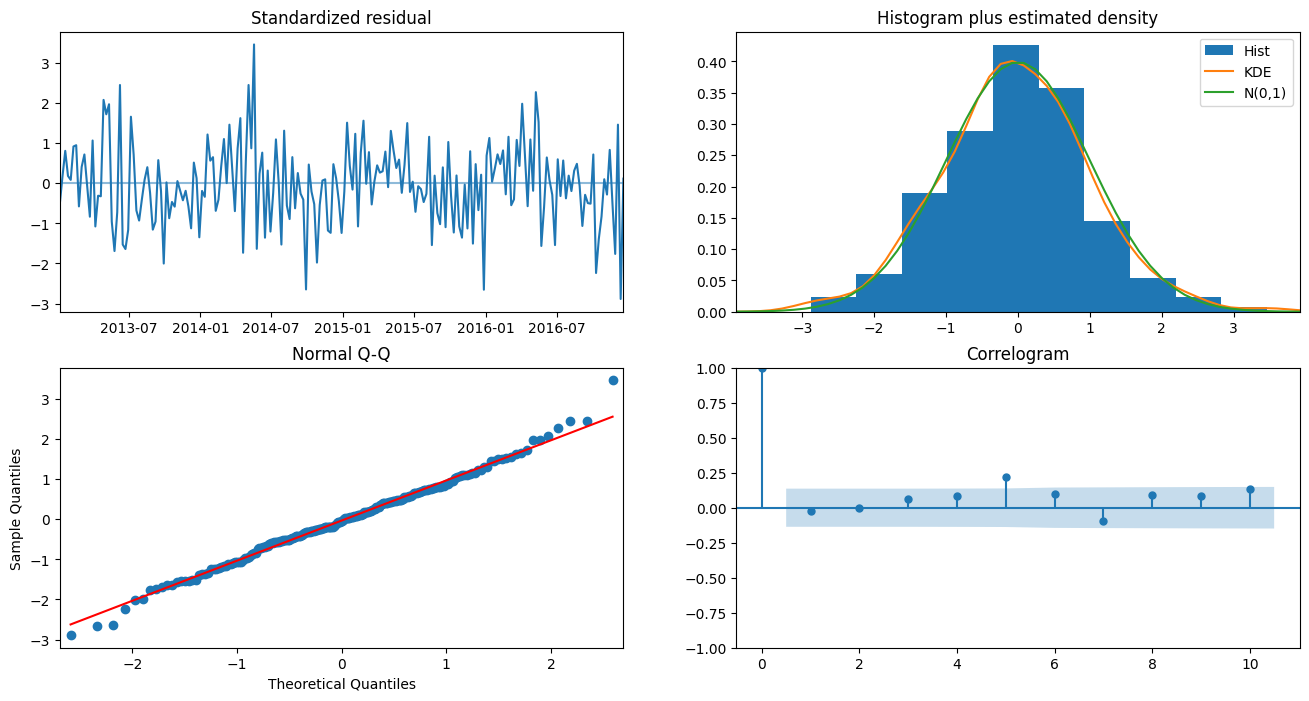

In [22]:
stepwise_model.plot_diagnostics(figsize=(16, 8))
plt.show()